In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
import re

# Create global dictionaries to store mappings
strategy_noise_colors = {}
strategy_noise_markers = {}

# Define a set of distinct, visually different colors
distinct_colors = list(mcolors.TABLEAU_COLORS.values())  # 10 distinct colors
distinct_colors.extend(list(mcolors.CSS4_COLORS.values())[::5])  # Add more distinct colors if needed

# Define a set of distinct markers
distinct_markers = ['o', 's', '^', 'D', '*', 'p', 'h', 'X', 'P', 'd', 'v', '<', '>']

def plot_training_metrics(folder_path, title_accuracy, title_loss, output_path):
    """
    Genera grafici di accuracy e loss da tutti i file CSV in una cartella.
    Mantiene colori e simboli consistenti per le stesse combinazioni strategy-noise tra chiamate diverse.
    Ordina la legenda in base al valore del rumore.
    
    Parameters:
    folder_path (str): Percorso della cartella contenente i file CSV.
                      Ogni file deve contenere le colonne 'round', 'accuracy' e 'loss'
    """
    global strategy_noise_colors, strategy_noise_markers, distinct_colors, distinct_markers
    
    # Converti il percorso in oggetto Path
    folder = Path(folder_path)
    
    # Trova tutti i file CSV nella cartella
    csv_files = list(folder.glob('*.csv'))
    
    if not csv_files:
        print(f"Nessun file CSV trovato in {folder_path}")
        return
        
    print(f"Trovati {len(csv_files)} file CSV")
    
    # Crea una figura con due subplot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Imposta uno stile grafico piacevole
    sns.set_style("whitegrid")
    
    # Lista per tenere traccia dei file e delle relative info per ordinamento
    file_info_list = []
    
    # Estrai informazioni su tutti i file per l'ordinamento
    for file_path in csv_files:
        try:
            filename = file_path.stem
            parts = filename.split('-')
            strategy = parts[0] if len(parts) > 0 else "Unknown"
            
            # Estrai il valore numerico del rumore per l'ordinamento
            noise_text = parts[-1] if len(parts) > 1 else "0"
            noise_value = 0
            # Cerca un valore numerico nel testo del rumore
            match = re.search(r'(\d+(\.\d+)?)', noise_text)
            if match:
                noise_value = float(match.group(1))
            
            noise_label = "Noise " + parts[-1] if len(parts) > 1 else "Unknown"
            legend_label = f"{strategy}-{noise_label}"
            
            file_info_list.append({
                'file_path': file_path,
                'strategy': strategy,
                'noise_value': noise_value,
                'noise_label': noise_label,
                'legend_label': legend_label
            })
        except Exception as e:
            print(f"Errore nell'analizzare {file_path.name}: {str(e)}")
    
    # Ordina i file in base al valore numerico del rumore
    file_info_list.sort(key=lambda x: x['noise_value'])
    
    # Ottieni tutte le combinazioni strategy-noise per questo set di file
    all_combinations = [info['legend_label'] for info in file_info_list]
    unique_combinations = []
    for combo in all_combinations:
        if combo not in unique_combinations:
            unique_combinations.append(combo)
    
    # Assegna colori e marker a nuove combinazioni non ancora mappate
    color_index = len(strategy_noise_colors)
    marker_index = len(strategy_noise_markers)
    
    for combo in unique_combinations:
        # Assegna un colore se non esiste già
        if combo not in strategy_noise_colors:
            if color_index < len(distinct_colors):
                strategy_noise_colors[combo] = distinct_colors[color_index]
                color_index += 1
            else:
                # Se finiamo i colori predefiniti, usiamo un colore casuale
                import random
                r = random.random()
                g = random.random()
                b = random.random()
                strategy_noise_colors[combo] = (r, g, b)
        
        # Assegna un marker se non esiste già
        if combo not in strategy_noise_markers:
            if marker_index < len(distinct_markers):
                strategy_noise_markers[combo] = distinct_markers[marker_index]
                marker_index += 1
            else:
                # Se finiamo i marker predefiniti, ricominciamo dal primo
                strategy_noise_markers[combo] = distinct_markers[marker_index % len(distinct_markers)]
                marker_index += 1
    
    # Processa ogni file CSV nell'ordine definito
    for info in file_info_list:
        try:
            file_path = info['file_path']
            legend_label = info['legend_label']
            
            # Leggi il CSV
            df = pd.read_csv(file_path)
            
            # Verifica che le colonne necessarie esistano
            required_columns = ['round', 'accuracy', 'loss']
            if not all(col in df.columns for col in required_columns):
                print(f"File {file_path.name} non ha tutte le colonne necessarie. Skip.")
                continue
            
            # Prendi il colore e il marker dalla mappa
            color = strategy_noise_colors[legend_label]
            marker = strategy_noise_markers[legend_label]
            
            # Plot accuracy
            ax1.plot(df['round'], df['accuracy'], 
                    label=legend_label, 
                    color=color, 
                    marker=marker, 
                    markersize=6,
                    markerfacecolor=color,
                    markeredgecolor='black',
                    markeredgewidth=0.5)
            
            # Plot loss
            ax2.plot(df['round'], df['loss'], 
                    label=legend_label, 
                    color=color, 
                    marker=marker, 
                    markersize=6,
                    markerfacecolor=color,
                    markeredgecolor='black',
                    markeredgewidth=0.5)
                    
        except Exception as e:
            print(f"Errore nel processare {file_path.name}: {str(e)}")
            continue
    
    # Configura il grafico dell'accuracy
    ax1.set_title(title_accuracy, fontsize=14, pad=15)
    ax1.set_xlabel('Rounds')
    ax1.set_ylabel('Accuracy')
    # Ordina la legenda in base all'ordine in cui le linee sono state aggiunte (già ordinate per rumore)
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles, labels, loc='lower right')
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    
    # Configura il grafico della loss
    ax2.set_title(title_loss, fontsize=14, pad=15)
    ax2.set_xlabel('Rounds')
    ax2.set_ylabel('Loss')
    # Ordina la legenda in base all'ordine in cui le linee sono state aggiunte (già ordinate per rumore)
    handles, labels = ax2.get_legend_handles_labels()
    ax2.legend(handles, labels, loc='lower right')
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    
    # Aggiusta il layout per evitare sovrapposizioni
    plt.tight_layout()
    
    # Crea una cartella 'plots' se non esiste
    output_folder = folder / 'plots'
    output_folder.mkdir(exist_ok=True)
    
    # Salva i grafici nella cartella plots
    
    plt.savefig(output_path, bbox_inches='tight', dpi=300)
    plt.close()
    
    print(f"Grafici salvati in: {output_path}")

parts[3]:  Distdirichlet
Trovati 6 file CSV


FileNotFoundError: [Errno 2] No such file or directory: '../brain-mri-tumor/plots/Clients30_C0.5_Distdirichlet.png'

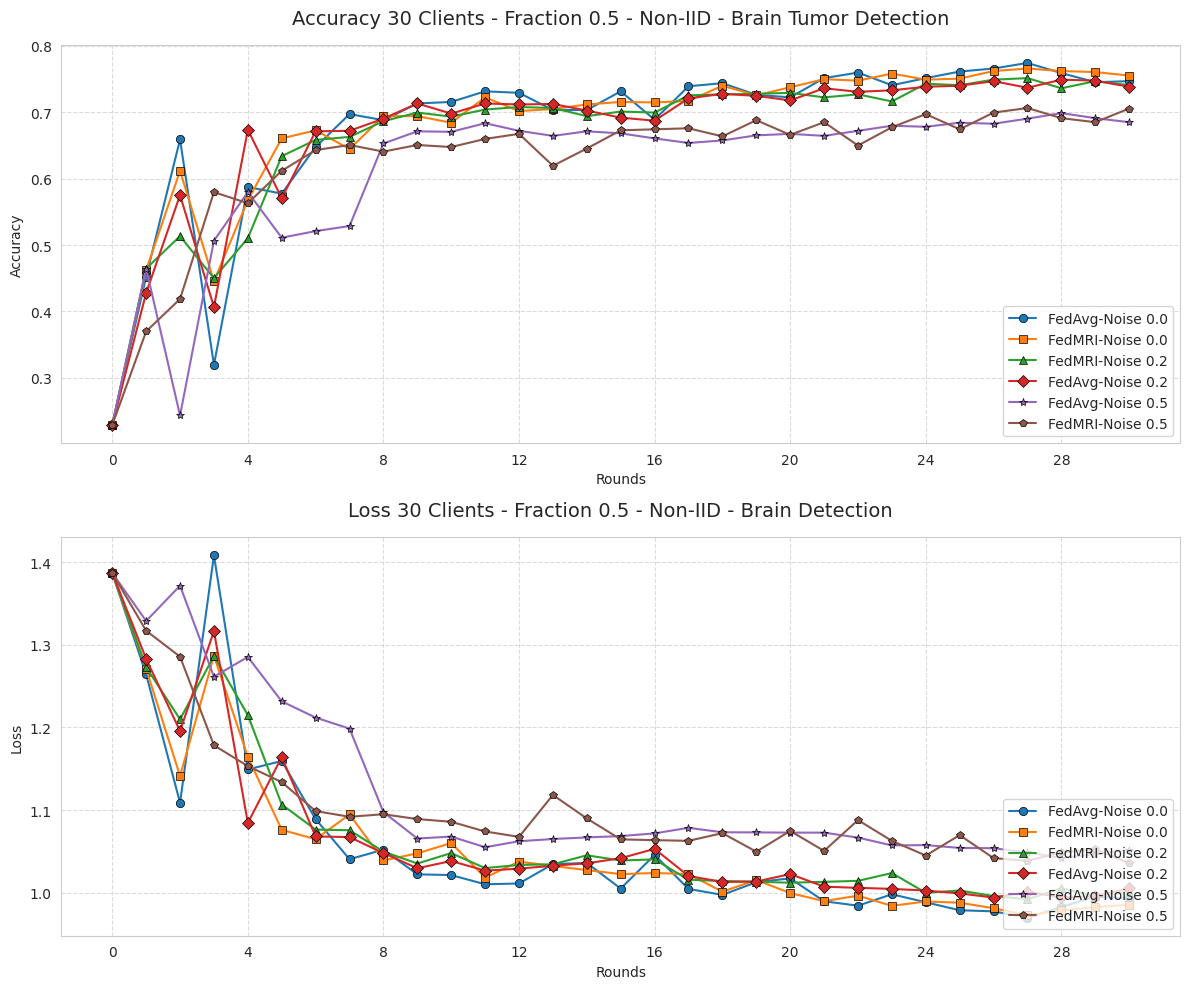

In [ ]:
import os

def generate_title(folder_name):
    parts = folder_name.split("_")  # Esempio: ["group", "Clients20", "C0.3", "Distiid"]
    clients = parts[1].replace("Clients", "")  # Estrae il numero di client
    fraction = parts[2].replace("C", "")  # Estrae la frazione
    
    # Mappa il tipo di distribuzione
    distribution_mapping = {
        "distiid": "IID",
        "distdirichlet": "Non-IID"
    }
    print("parts[3]: ", parts[3])
    distribution_key = parts[3].lower()  # Converte in minuscolo per evitare problemi
    distribution = distribution_mapping.get(distribution_key, "Unknown")

    title_acc = f"Accuracy {clients} Clients - Fraction {fraction} - {distribution} - Brain Tumor Detection"
    title_loss = f"Loss {clients} Clients - Fraction {fraction} - {distribution} - Brain Tumor Detection"
    
    return title_acc, title_loss

base_path = "../brain-mri-tumor"
#os.makedirs(output_plot_folder, exist_ok=True)

for folder in os.listdir(base_path):
    if folder.startswith("group_"):
        result_path = os.path.join(base_path, folder)
        title_acc, title_loss = generate_title(folder)
        name_without_group = folder.replace("group_", "")
        name_file_plot = f"{name_without_group}.png"
        output_plot_folder = base_path + "/plots/" + name_file_plot
        plot_training_metrics(result_path, title_acc, title_loss, output_plot_folder)
